# 🌊 SeaLake Land Cover Analysis - EuroSAT Multispectral Dataset

## Overview
This notebook provides a comprehensive analysis of SeaLake class satellite imagery from the EuroSAT multispectral dataset. We'll explore spectral signatures, water indices, and other characteristics using Sentinel-2 data.

## What You'll Learn:
- ✅ Dataset validation and structure exploration
- ✅ Dataset balancing to a uniform size (if needed)
- 📊 Multispectral band analysis and statistics
- 💧 Water index calculations (NDWI, MNDWI)
- 🌐 Comparative analysis with other land cover types
- 📈 Statistical analysis of water bodies

## 🔧 Step 1: Setup and Data Loading

First, let's import the necessary libraries and set up our environment.

🚀 Starting SeaLake Analysis at 2025-09-19 00:23:45
✅ Dataset found: T:\DEPI final Project\EuroSAT_MS
✅ Found 10 land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake
✅ SeaLake class folder verified: T:\DEPI final Project\EuroSAT_MS\SeaLake

📊 Dataset Composition (files per class):
  ✅ AnnualCrop      : 2,000 images
  ✅ Forest          : 2,000 images
  ✅ HerbaceousVegetation : 2,000 images
  ✅ Highway         : 2,000 images
  ✅ Industrial      : 2,000 images
  ✅ Pasture         : 2,000 images
  ✅ PermanentCrop   : 2,000 images
  ✅ Residential     : 2,000 images
  ✅ River           : 2,000 images
  ✅ SeaLake         : 2,000 images

🌊 SeaLake Dataset Summary:
   📁 Total SeaLake images: 2,000
   📄 Sample filenames:
      1. SeaLake_1.tif
      2. SeaLake_100.tif
      3. SeaLake_1000.tif
      4. SeaLake_1001.tif
      5. SeaLake_1002.tif
      ... and 1995 more


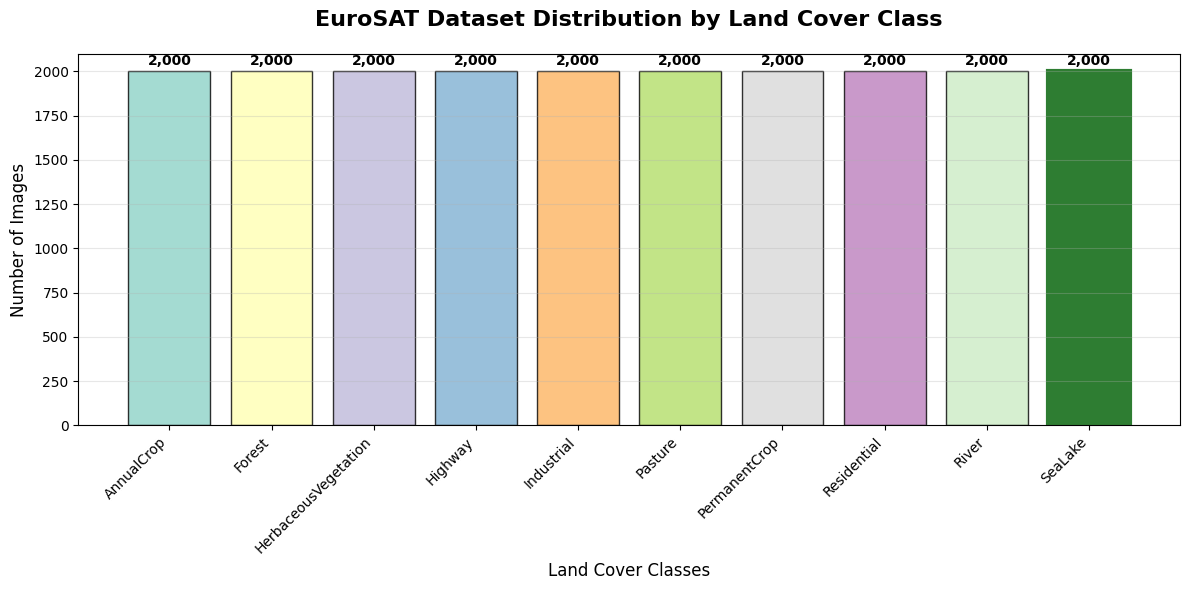


✨ Setup completed successfully! Ready to analyze 2,000 SeaLake images.


In [1]:
# ====== STEP 1: Dataset Setup and Validation ======
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set a consistent style for visualizations
plt.style.use('default')
sns.set_palette("husl")

# --- Path and Class Configuration ---
# IMPORTANT: Update DATA_DIR with the correct path to your EuroSAT_MS folder
DATA_DIR = Path(r"T:\DEPI final Project\EuroSAT_MS")
CLASS_NAME = "SeaLake"

print(f"🚀 Starting SeaLake Analysis at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# --- Dataset Validation ---
if not DATA_DIR.exists():
    raise FileNotFoundError(f"❌ ERROR: Dataset folder not found at: {DATA_DIR}\n"
                        f"Please update DATA_DIR with the correct path to your EuroSAT_MS folder.")
print(f"✅ Dataset found: {DATA_DIR}")

classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
if len(classes) == 0:
    raise FileNotFoundError(f"❌ ERROR: No class folders found inside: {DATA_DIR}\n"
                        f"Expected folders like 'Forest', 'River', etc.")
print(f"✅ Found {len(classes)} land cover classes: {', '.join(classes)}")

sea_lake_dir = DATA_DIR / CLASS_NAME
if not sea_lake_dir.exists():
    raise FileNotFoundError(f"❌ ERROR: '{CLASS_NAME}' folder not found at: {sea_lake_dir}")
print(f"✅ SeaLake class folder verified: {sea_lake_dir}")

# --- Dataset Overview ---
print("\n📊 Dataset Composition (files per class):")
counts = {}
for c in classes:
    count = len(list((DATA_DIR / c).glob("*.tif")))
    counts[c] = count
    status = "✅" if count > 0 else "⚠️"
    print(f"  {status} {c:<15} : {count:,} images")

sea_lake_tifs = sorted(sea_lake_dir.glob("*.tif"))
if len(sea_lake_tifs) == 0:
    raise FileNotFoundError(f"❌ ERROR: No .tif files found in {sea_lake_dir}")
print(f"\n🌊 SeaLake Dataset Summary:")
print(f"   📁 Total SeaLake images: {len(sea_lake_tifs):,}")
print(f"   📄 Sample filenames:")
for i, p in enumerate(sea_lake_tifs[:5]):
    print(f"      {i+1}. {p.name}")
if len(sea_lake_tifs) > 5:
    print(f"      ... and {len(sea_lake_tifs)-5} more")

# --- Visualize Dataset Distribution ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
classes_sorted = sorted(counts.keys(), key=lambda x: counts[x], reverse=True)
values = [counts[c] for c in classes_sorted]
colors = plt.cm.Set3(np.linspace(0, 1, len(classes_sorted)))

bars = plt.bar(classes_sorted, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.title('EuroSAT Dataset Distribution by Land Cover Class', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Land Cover Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Highlight the bar for the current class
if 'SeaLake' in classes_sorted:
    sea_lake_idx = classes_sorted.index('SeaLake')
    bars[sea_lake_idx].set_color('#2E7D32')
    bars[sea_lake_idx].set_alpha(1.0)
    bars[sea_lake_idx].set_linewidth(3)
    
plt.tight_layout()
plt.show()

print(f"\n✨ Setup completed successfully! Ready to analyze {len(sea_lake_tifs):,} SeaLake images.")
print("=" * 60)


## ⚖️ Step 2: Balance Dataset Image Count


In [2]:
# ====== STEP 2: Balance Dataset Image Count =====
import random
import os

print("🔄 Starting dataset balancing...")
print("=" * 50)

# Set the target number of images per class
TARGET_COUNT = 2000

# Iterate over all class directories to ensure uniform size
for class_name in classes:
    class_dir = DATA_DIR / class_name
    files = sorted(list(class_dir.glob("*.tif")))
    current_count = len(files)

    if current_count > TARGET_COUNT:
        print(f"🗑️ {class_name}: Found {current_count:,} images, targeting {TARGET_COUNT:,}.")
        
        # Randomly select files to delete
        num_to_delete = current_count - TARGET_COUNT
        files_to_delete = random.sample(files, num_to_delete)
        
        # Delete the selected files
        for f in files_to_delete:
            os.remove(f)
        
        print(f"   ✅ Deleted {num_to_delete:,} images. New count: {len(list(class_dir.glob('*.tif'))):,}.")
    else:
        print(f"👍 {class_name}: Image count {current_count:,} is already at or below target.")

print("\n✨ Dataset balancing complete!")
print("=" * 50)


🔄 Starting dataset balancing...
👍 AnnualCrop: Image count 2,000 is already at or below target.
👍 Forest: Image count 2,000 is already at or below target.
👍 HerbaceousVegetation: Image count 2,000 is already at or below target.
👍 Highway: Image count 2,000 is already at or below target.
👍 Industrial: Image count 2,000 is already at or below target.
👍 Pasture: Image count 2,000 is already at or below target.
👍 PermanentCrop: Image count 2,000 is already at or below target.
👍 Residential: Image count 2,000 is already at or below target.
👍 River: Image count 2,000 is already at or below target.
👍 SeaLake: Image count 2,000 is already at or below target.

✨ Dataset balancing complete!


## 🔬 Step 3: Deep Dive into Multispectral SeaLake Imagery


🔍 Analyzing sample: SeaLake_1.tif
📏 Spatial Dimensions: 64 × 64 pixels
📊 Spectral Bands: 13 bands
🗂️ Data Type: uint16
🌍 Coordinate System: EPSG:32633
📐 Pixel Size: 10.0m × 10.0m
📍 Geographic Bounds:
   West: 547713.670878, East: 548353.842116
   North: 6426342.401814, South: 6425702.312786

📈 Detailed Band Statistics:
Band   Name         Wavelength Min      Mean     Max      Std      Non-Zero% 
---------------------------------------------------------------------------
B01    Coastal Aerosol 443nm      1037     1043     1051     1.7      100.0     
B02    Blue         490nm      689      716      824      8.0      100.0     
B03    Green        560nm      413      440      618      7.0      100.0     
B04    Red          665nm      227      249      451      7.5      100.0     
B05    Red Edge 1   705nm      203      214      422      8.2      100.0     
B06    Red Edge 2   740nm      174      186      500      12.5     100.0     
B07    Red Edge 3   783nm      155      168      562  

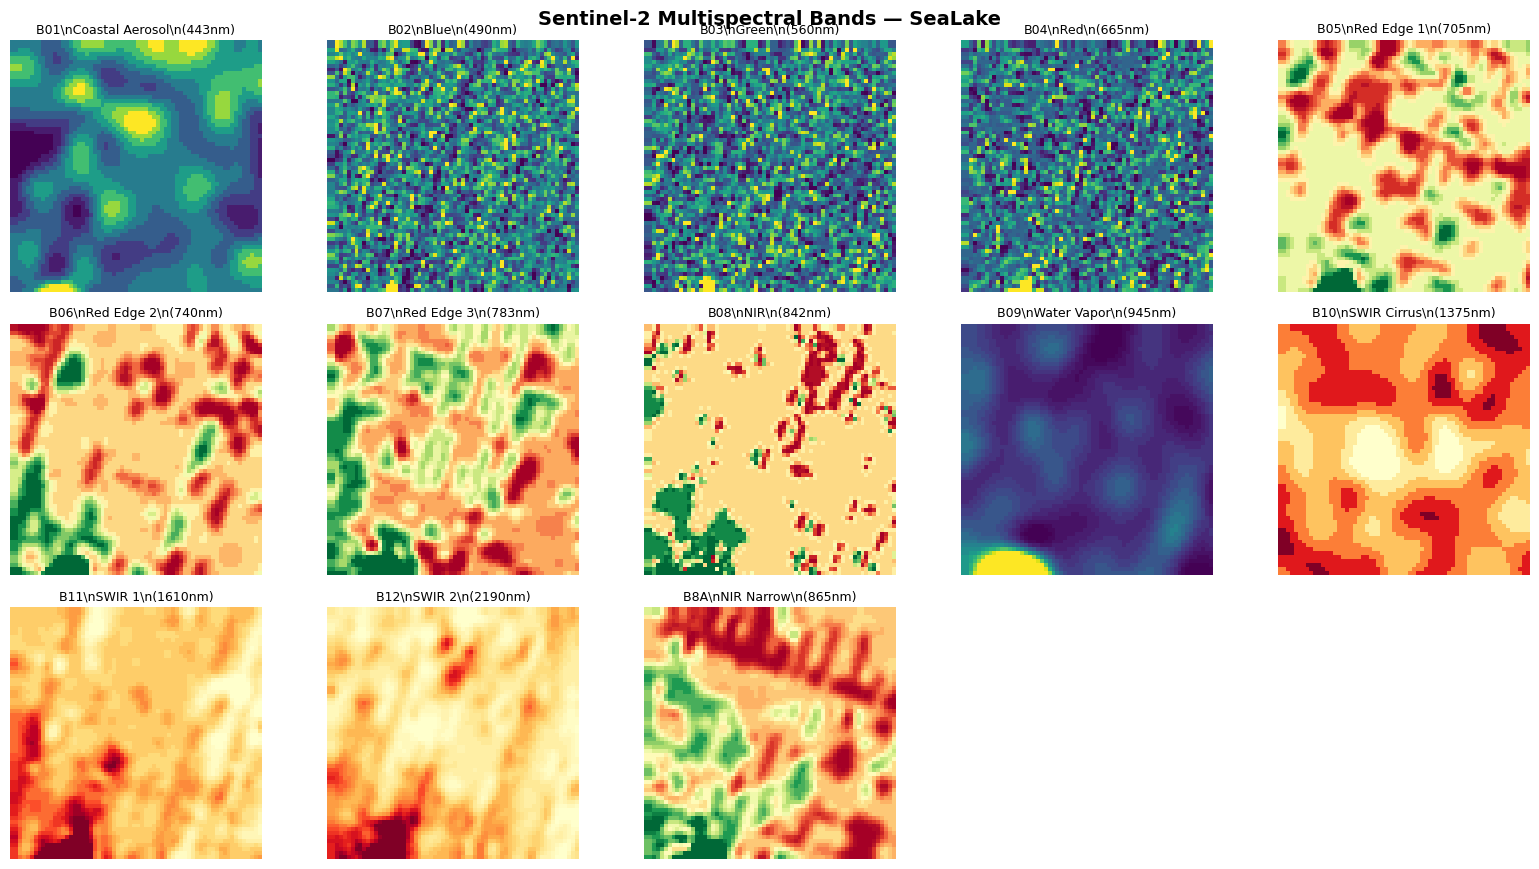


🌈 Creating RGB True Color Composite...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_19120\2512444187.py:95: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
c:\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


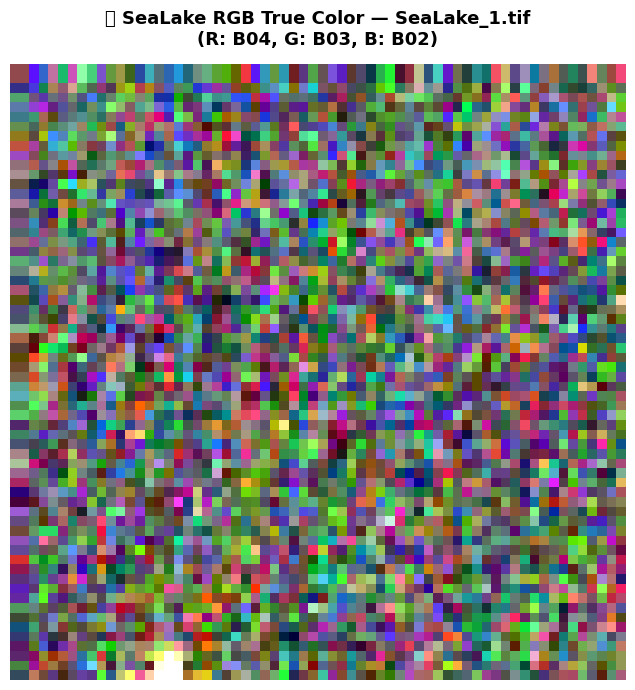


🌿 Computing Water & Vegetation Indices...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_19120\2512444187.py:123: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()


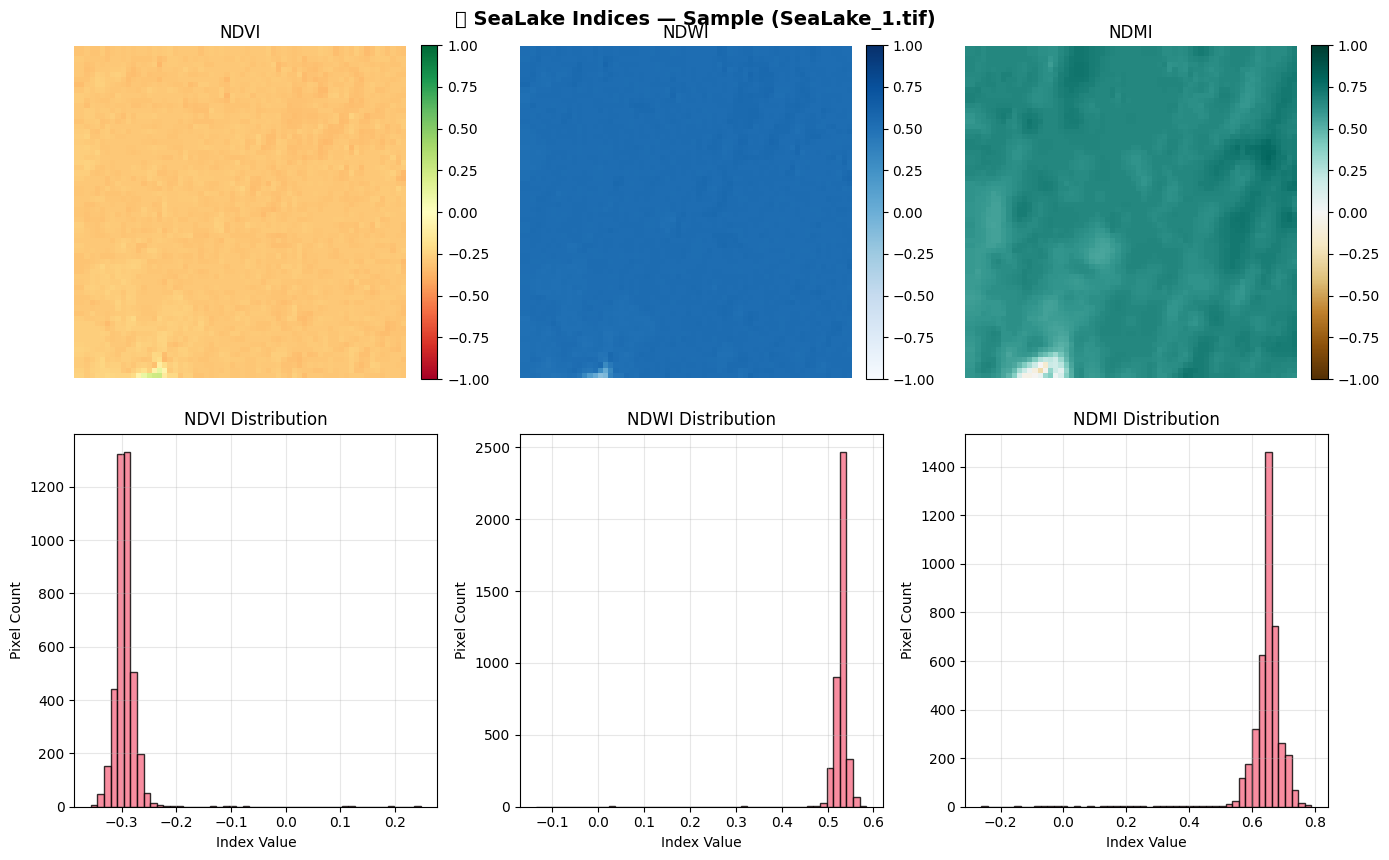

✅ Deep multispectral analysis for SeaLake completed!


In [3]:
# ====== STEP 3: Deep Multispectral Analysis of Single SeaLake Image ======
import rasterio
import numpy as np
import matplotlib.pyplot as plt

sample_paths = sorted((DATA_DIR / CLASS_NAME).glob("*.tif"))
sample = sample_paths[0]
print(f"🔍 Analyzing sample: {sample.name}")
print("=" * 50)

with rasterio.open(sample) as src:
    band_count = src.count
    height, width = src.height, src.width
    crs = src.crs
    transform = src.transform
    dtype = src.dtypes[0]
    bounds = src.bounds
    
    print(f"📏 Spatial Dimensions: {height} × {width} pixels")
    print(f"📊 Spectral Bands: {band_count} bands")
    print(f"🗂️ Data Type: {dtype}")
    print(f"🌍 Coordinate System: {crs}")
    print(f"📐 Pixel Size: {abs(transform[0]):.1f}m × {abs(transform[4]):.1f}m")
    print(f"📍 Geographic Bounds:")
    print(f"   West: {bounds.left:.6f}, East: {bounds.right:.6f}")
    print(f"   North: {bounds.top:.6f}, South: {bounds.bottom:.6f}")

SENTINEL2_BANDS = {
    1: ('B01', 'Coastal Aerosol', '443nm', 60), 2: ('B02', 'Blue', '490nm', 10),
    3: ('B03', 'Green', '560nm', 10), 4: ('B04', 'Red', '665nm', 10),
    5: ('B05', 'Red Edge 1', '705nm', 20), 6: ('B06', 'Red Edge 2', '740nm', 20),
    7: ('B07', 'Red Edge 3', '783nm', 20), 8: ('B08', 'NIR', '842nm', 10),
    9: ('B09', 'Water Vapor', '945nm', 60), 10: ('B10', 'SWIR Cirrus', '1375nm', 60),
    11: ('B11', 'SWIR 1', '1610nm', 20), 12: ('B12', 'SWIR 2', '2190nm', 20),
    13: ('B8A', 'NIR Narrow', '865nm', 20)
}

def enhanced_stretch(x, percentiles=(2, 98), gamma=1.0):
    x = x.astype(np.float32)
    valid = x[x > 0]
    if valid.size == 0:
        valid = x
    lo, hi = np.percentile(valid, percentiles)
    stretched = np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)
    return np.power(stretched, 1/gamma)

with rasterio.open(sample) as src:
    all_bands = [src.read(b).astype(np.float32) for b in range(1, band_count+1)]

print("\n📈 Detailed Band Statistics:")
print(f"{'Band':<6} {'Name':<12} {'Wavelength':<10} {'Min':<8} {'Mean':<8} {'Max':<8} {'Std':<8} {'Non-Zero%':<10}")
print("-" * 75)

band_stats = []
for i, arr in enumerate(all_bands, start=1):
    band_info = SENTINEL2_BANDS.get(i, (f'B{i:02d}', 'Unknown', 'N/A', 'N/A'))
    non_zero_pct = (np.count_nonzero(arr) / arr.size) * 100
    stats = {'band': band_info[0],'name': band_info[1],'wavelength': band_info[2],'resolution': band_info[3],
             'min': float(arr.min()),'mean': float(arr.mean()),'max': float(arr.max()),'std': float(arr.std()),'non_zero_pct': non_zero_pct}
    band_stats.append(stats)
    print(f"{band_info[0]:<6} {band_info[1]:<12} {band_info[2]:<10} {arr.min():<8.0f} {arr.mean():<8.0f} {arr.max():<8.0f} {arr.std():<8.1f} {non_zero_pct:<10.1f}")

fig = plt.figure(figsize=(16, 9))
cols, rows = 5, 3
for i, stats in enumerate(band_stats[:13], start=1):
    arr = all_bands[i-1]
    ax = fig.add_subplot(rows, cols, i)
    if 'NIR' in stats['name'] or 'Red Edge' in stats['name']:
        cmap = 'RdYlGn'
    elif 'SWIR' in stats['name']:
        cmap = 'YlOrRd'
    else:
        cmap = 'viridis'
    im = ax.imshow(enhanced_stretch(arr, gamma=0.8), cmap=cmap)
    ax.set_title(f"{stats['band']}\\n{stats['name']}\\n({stats['wavelength']})", fontsize=9, pad=5)
    ax.axis('off')
plt.suptitle(f"Sentinel-2 Multispectral Bands — {CLASS_NAME}", fontsize=14, fontweight='bold', y=0.96)
plt.tight_layout(); plt.show()

print("\n🌈 Creating RGB True Color Composite...")
with rasterio.open(sample) as src:
    red   = src.read(4).astype(np.float32)
    green = src.read(3).astype(np.float32)
    blue  = src.read(2).astype(np.float32)

rgb = np.dstack([
    enhanced_stretch(red,   percentiles=(1, 99), gamma=0.8),
    enhanced_stretch(green, percentiles=(1, 99), gamma=0.8),
    enhanced_stretch(blue,  percentiles=(1, 99), gamma=0.8)
])

plt.figure(figsize=(8, 7))
plt.imshow(rgb); plt.axis('off')
plt.title(f"🌊 SeaLake RGB True Color — {sample.name}\n(R: B04, G: B03, B: B02)", fontsize=13, fontweight='bold', pad=14)
plt.tight_layout(); plt.show()

print("\n🌿 Computing Water & Vegetation Indices...")
with rasterio.open(sample) as src:
    nir   = src.read(8).astype(np.float32)
    red   = src.read(4).astype(np.float32)
    green = src.read(3).astype(np.float32)
    swir1 = src.read(11).astype(np.float32)

# Vegetation (NDVI)
ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)

# Water Index (NDWI)
ndwi = (green - nir) / (green + nir + 1e-6); ndwi = np.clip(ndwi, -1, 1)

# Normalized Difference Moisture Index (NDMI)
ndmi = (nir - swir1) / (nir + swir1 + 1e-6); ndmi = np.clip(ndmi, -1, 1)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
im1 = axes[0,0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1); axes[0,0].set_title('NDVI'); axes[0,0].axis('off'); plt.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04)
im2 = axes[0,1].imshow(ndwi, cmap='Blues', vmin=-1, vmax=1); axes[0,1].set_title('NDWI'); axes[0,1].axis('off'); plt.colorbar(im2, ax=axes[0,1], fraction=0.046, pad=0.04)
im3 = axes[0,2].imshow(ndmi, cmap='BrBG', vmin=-1, vmax=1); axes[0,2].set_title('NDMI'); axes[0,2].axis('off'); plt.colorbar(im3, ax=axes[0,2], fraction=0.046, pad=0.04)

for i, (arr, title) in enumerate(zip([ndvi, ndwi, ndmi], ['NDVI Distribution','NDWI Distribution','NDMI Distribution'])):
    axes[1,i].hist(arr.ravel(), bins=50, alpha=0.8, edgecolor='black')
    axes[1,i].set_title(title); axes[1,i].set_xlabel('Index Value'); axes[1,i].set_ylabel('Pixel Count'); axes[1,i].grid(True, alpha=0.3)

plt.suptitle(f"🌊 SeaLake Indices — Sample ({sample.name})", fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout(); plt.show()

print("✅ Deep multispectral analysis for SeaLake completed!")
print("=" * 50)


## 🔄 Step 4: Comparative Analysis Across SeaLake


🔄 Comparing multiple SeaLake patches (RGB + NDWI + Histogram)...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_19120\865016373.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


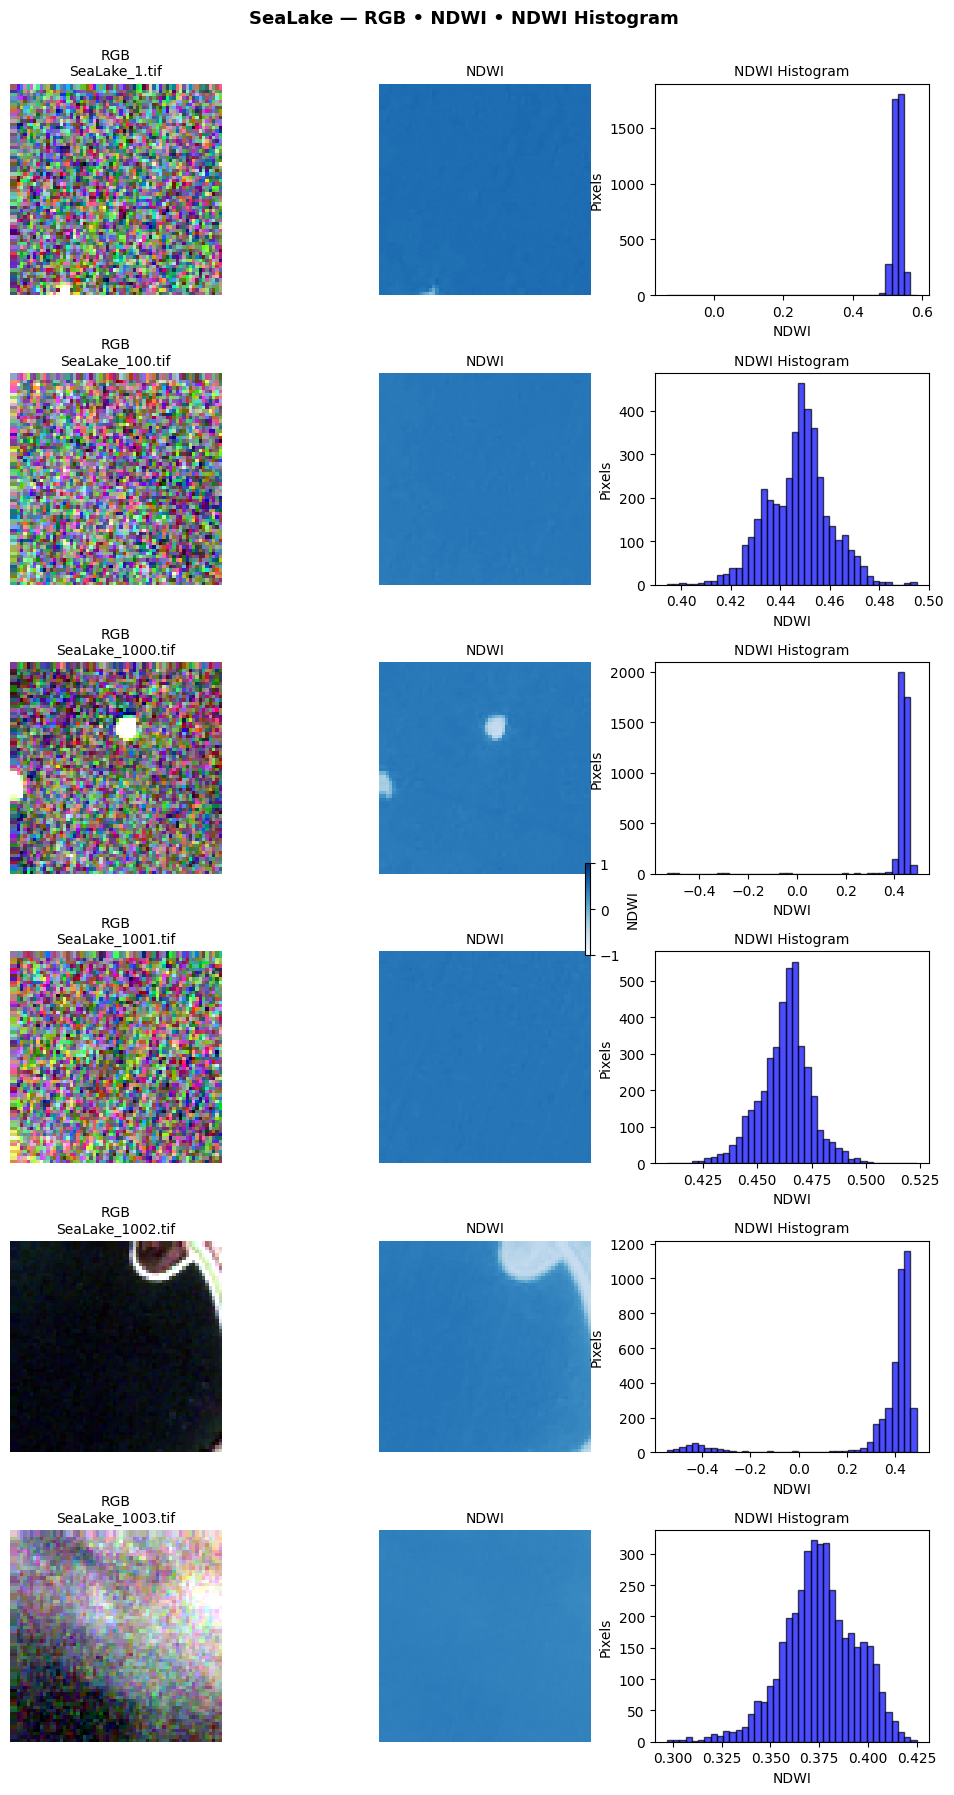

✅ Step 4 (SeaLake) done.


In [4]:
# ====== STEP 4: Side-by-Side RGB • NDWI • NDWI Histograms (SeaLake) ======
import numpy as np
import matplotlib.pyplot as plt
import rasterio

print("🔄 Comparing multiple SeaLake patches (RGB + NDWI + Histogram)...")
sea_dir = DATA_DIR / CLASS_NAME
files = sorted(sea_dir.glob("*.tif"))
assert len(files) > 0, f"No .tif files found in {sea_dir}"

# --- Function to apply contrast stretch for better visualization ---
def stretch01(x, p=(2, 98)):
    x = x.astype("float32")
    nonzero = x[x > 0]
    lo, hi = np.percentile(nonzero if nonzero.size else x, p)
    return np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)

# --- Function to read specific bands from a .tif file ---
def read_bands(path, idxs):
    with rasterio.open(path) as src:
        return [src.read(i).astype("float32") for i in idxs]

# --- Select a subset of images for comparison ---
N = min(6, len(files))
subset = files[:N]

# --- Create a grid of subplots ---
fig, axes = plt.subplots(N, 3, figsize=(10, 3*N))
if N == 1:
    axes = np.array([axes])

last_im = None
for i, p in enumerate(subset):
    # RGB
    r, g, b = read_bands(p, [4, 3, 2])
    rgb = np.dstack([stretch01(r), stretch01(g), stretch01(b)])
    axes[i, 0].imshow(rgb); axes[i, 0].axis("off")
    axes[i, 0].set_title(f"RGB\n{p.name}", fontsize=10)

    # NDWI (Normalized Difference Water Index)
    g_band, nir = read_bands(p, [3, 8])
    ndwi = (g_band - nir) / (g_band + nir + 1e-6); ndwi = np.clip(ndwi, -1, 1)
    last_im = axes[i, 1].imshow(ndwi, cmap="Blues", vmin=-1, vmax=1)
    axes[i, 1].set_title("NDWI", fontsize=10); axes[i, 1].axis("off")

    # Histogram
    axes[i, 2].hist(ndwi.ravel(), bins=40, color="blue", alpha=0.7, edgecolor="black")
    axes[i, 2].set_title("NDWI Histogram", fontsize=10)
    axes[i, 2].set_xlabel("NDWI"); axes[i, 2].set_ylabel("Pixels")

if last_im is not None:
    cbar = plt.colorbar(last_im, ax=axes[:, 1], fraction=0.02)
    cbar.set_label("NDWI")

plt.suptitle(f"{CLASS_NAME} — RGB • NDWI • NDWI Histogram", y=0.995, fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()
print("✅ Step 4 (SeaLake) done.")


## 📊 Step 5: Large-Scale SeaLake Spectral Statistics


📊 Starting Large-Scale SeaLake Spectral Analysis (NDWI)...
📁 Analyzing 1,000 SeaLake images out of 2,000 available
⚡ Using 4 threads for parallel processing
📏 Image dimensions: 64 × 64 pixels
📊 Spectral bands: 13
  → Processed 100/1000 images...
  → Processed 200/1000 images...
  → Processed 300/1000 images...
  → Processed 400/1000 images...
  → Processed 500/1000 images...
  → Processed 600/1000 images...
  → Processed 700/1000 images...
  → Processed 800/1000 images...
  → Processed 900/1000 images...
  → Processed 1000/1000 images...
⏱️ Finished in 12.0s | Success: 1000 | Errors: 0


,filename,band_1_mean,band_1_std,band_1_min,band_1_max,band_1_median,band_1_p05,band_1_p95,band_1_nonzero_pct,band_2_mean,...,band_12_nonzero_pct,band_13_mean,band_13_std,band_13_min,band_13_max,band_13_median,band_13_p05,band_13_p95,band_13_nonzero_pct,ndwi_mean
0,SeaLake_1.tif,1042.983398,1.697947,1037.0,1051.0,1043.0,1040.0,1046.0,100.0,716.423828,...,100.0,119.756104,18.213934,107.0,594.0,118.0,109.0,128.00,100.0,0.528521
1,SeaLake_1000.tif,1217.375732,3.279715,1206.0,1229.0,1218.0,1212.0,1222.0,100.0,822.651855,...,100.0,206.975342,137.846207,163.0,2056.0,186.0,172.0,211.25,100.0,0.426302
2,SeaLake_100.tif,1213.282959,3.149244,1205.0,1222.0,1213.0,1208.0,1218.0,100.0,818.728516,...,100.0,181.914795,7.392413,159.0,204.0,181.0,170.0,193.00,100.0,0.447070
3,SeaLake_1001.tif,1055.446289,2.629004,1049.0,1063.0,1055.0,1051.0,1060.0,100.0,721.540283,...,100.0,153.897705,5.085359,139.0,176.0,153.0,146.0,163.00,100.0,0.462690
4,SeaLake_1003.tif,1297.958984,14.771709,1270.0,1335.0,1303.0,1273.0,1321.0,100.0,996.572266,...,100.0,378.354248,25.822472,328.0,477.0,379.0,338.0,420.00,100.0,0.375271


,band,name,wavelength,resolution,mean_of_means,std_of_means,p05_mean,p95_mean,mean_of_stds,mean_p05,mean_p95,avg_nonzero_pct,n_images
0,B01,B01-Coastal,443nm,60,1238.301473,152.427748,1052.647302,1485.127173,11.668692,1222.86550,1259.00025,100.0,1000
1,B02,B02-Blue,490nm,10,957.714225,193.334729,723.867456,1330.498779,24.224920,925.01425,994.43575,100.0,1000
2,B03,B03-Green,560nm,10,783.814665,289.867313,452.655737,1329.465979,33.283382,739.65175,834.69825,100.0,1000
3,B04,B04-Red,665nm,10,514.106969,266.333289,238.787927,1019.018066,38.229124,472.65325,576.13850,100.0,1000
4,B05,B05-RedEdge1,705nm,20,510.860789,299.916386,199.733020,1065.572595,45.892402,470.89200,600.98125,100.0,1000
5,B06,B06-RedEdge2,740nm,20,403.854042,230.525120,174.970898,886.869189,107.881880,342.17625,634.14200,100.0,1000
6,B07,B07-RedEdge3,783nm,20,405.831707,258.701300,151.261743,962.312305,133.751823,331.90425,691.70725,100.0,1000
7,B08,B08-NIR,842nm,10,340.799841,229.753423,124.570752,851.535852,143.112232,267.23575,636.03150,100.0,1000
8,B09,B09-WaterVapor,945nm,60,99.299685,58.352712,55.885291,228.057629,40.196229,75.09250,190.26025,100.0,1000
9,B10,B10-Cirrus,1375nm,60,7.700667,2.257467,5.238501,11.121973,1.064844,6.11350,9.48900,100.0,1000


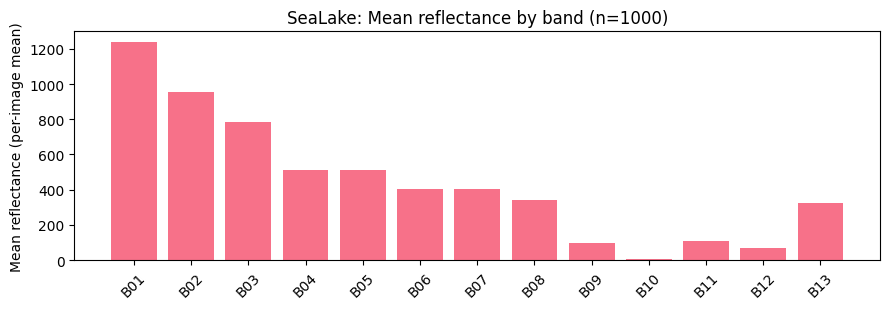

C:\Users\tadoa\AppData\Local\Temp\ipykernel_19120\2186434609.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(figsize=(10, 3.6)); plt.boxplot(data_for_box, labels=[f'B{b:02d}' for b in range(1, band_count+1)], showfliers=False)


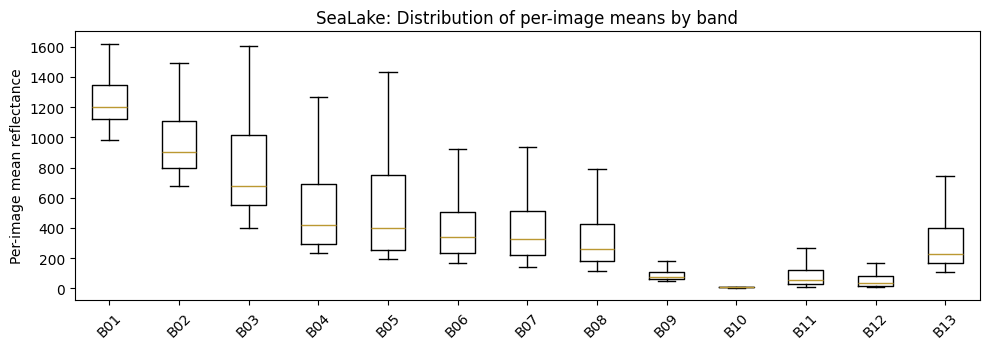

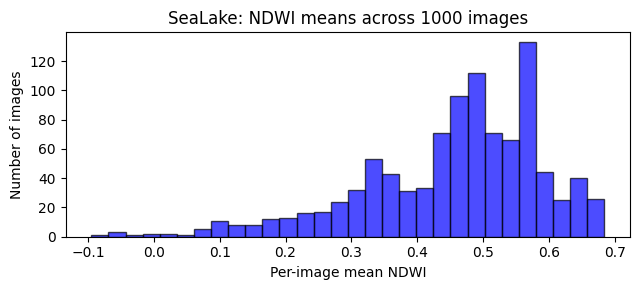


🔎 Takeaways:
- Highest SeaLake reflectance bands: B01(B01-Coastal), B02(B02-Blue), B03(B03-Green), B04(B04-Red), B05(B05-RedEdge1)
- Lowest reflectance (often atmospheric/less useful): B10(B10-Cirrus), B12(B12-SWIR2), B09(B09-WaterVapor)
✅ Step 5 done.


In [5]:
# ====== STEP 5: Large-Scale SeaLake Spectral Statistics (with NDWI) ======
import time
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
import pandas as pd

# Suppress non-critical rasterio warnings
warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)

print("📊 Starting Large-Scale SeaLake Spectral Analysis (NDWI)...")
print("=" * 60)

sea_dir = DATA_DIR / CLASS_NAME
files = sorted(sea_dir.glob("*.tif"))
assert len(files) > 0, f"No .tif files found in {sea_dir}"

MAX_SAMPLES = min(1000, len(files))
N_THREADS   = 4
selected_files = files[:MAX_SAMPLES]
print(f"📁 Analyzing {len(selected_files):,} SeaLake images out of {len(files):,} available")
print(f"⚡ Using {N_THREADS} threads for parallel processing")

with rasterio.open(selected_files[0]) as src0:
    band_count = src0.count
    sample_height, sample_width = src0.height, src0.width
print(f"📏 Image dimensions: {sample_height} × {sample_width} pixels")
print(f"📊 Spectral bands: {band_count}")

SENTINEL2_DETAILED = {
     1: {'name': 'B01-Coastal',    'wavelength': '443nm',  'resolution': 60},
     2: {'name': 'B02-Blue',       'wavelength': '490nm',  'resolution': 10},
     3: {'name': 'B03-Green',      'wavelength': '560nm',  'resolution': 10},
     4: {'name': 'B04-Red',        'wavelength': '665nm',  'resolution': 10},
     5: {'name': 'B05-RedEdge1',   'wavelength': '705nm',  'resolution': 20},
     6: {'name': 'B06-RedEdge2',   'wavelength': '740nm',  'resolution': 20},
     7: {'name': 'B07-RedEdge3',   'wavelength': '783nm',  'resolution': 20},
     8: {'name': 'B08-NIR',        'wavelength': '842nm',  'resolution': 10},
     9: {'name': 'B09-WaterVapor', 'wavelength': '945nm',  'resolution': 60},
    10: {'name': 'B10-Cirrus',     'wavelength': '1375nm', 'resolution': 60},
    11: {'name': 'B11-SWIR1',      'wavelength': '1610nm', 'resolution': 20},
    12: {'name': 'B12-SWIR2',      'wavelength': '2190nm', 'resolution': 20},
    13: {'name': 'B8A-NIRNarrow',  'wavelength': '865nm',  'resolution': 20},
}

def per_band_stats(arr: np.ndarray):
    """Compute statistics for a single band."""
    x = arr.astype(np.float32)
    valid = x[x > 0]
    if valid.size == 0:
        return {'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
                'median': np.nan, 'p05': np.nan, 'p95': np.nan, 'nonzero_pct': 0.0}
    return {
        'mean': float(valid.mean()), 'std': float(valid.std()), 'min': float(valid.min()), 'max': float(valid.max()),
        'median': float(np.median(valid)), 'p05': float(np.percentile(valid, 5)), 'p95': float(np.percentile(valid, 95)),
        'nonzero_pct': float(100 * valid.size / x.size)
    }

def process_single_image(filepath):
    """Process a single image and compute band stats and NDWI."""
    try:
        with rasterio.open(filepath) as src:
            if src.count != band_count:
                return None, f"Band mismatch in {filepath.name}: expected {band_count}, got {src.count}"
            stats = {'filename': filepath.name}
            cache = {}
            for b in range(1, band_count+1):
                arr = src.read(b)
                cache[b] = arr
                s = per_band_stats(arr)
                for k, v in s.items():
                    stats[f'band_{b}_{k}'] = v

            # Compute NDWI = (Green - NIR) / (Green + NIR)
            green = cache[3].astype(np.float32)
            nir   = cache[8].astype(np.float32)
            ndwi = (green - nir) / (green + nir + 1e-6)
            ndwi = np.clip(ndwi, -1, 1)
            stats['ndwi_mean'] = float(np.nanmean(ndwi))

            return stats, None
    except Exception as e:
        return None, f"Error {filepath.name}: {e}"

results, errors = [], []
t0 = time.time()
with ThreadPoolExecutor(max_workers=N_THREADS) as ex:
    futs = {ex.submit(process_single_image, fp): fp for fp in selected_files}
    for i, fut in enumerate(as_completed(futs), 1):
        res, err = fut.result()
        if res is not None: results.append(res)
        if err is not None: errors.append(err)
        if i % 100 == 0 or i == len(selected_files):
            print(f"  → Processed {i}/{len(selected_files)} images...")
print(f"⏱️ Finished in {time.time()-t0:.1f}s | Success: {len(results)} | Errors: {len(errors)}")
if errors:
    print("\n".join(errors[:3]))

df = pd.DataFrame(results); assert len(df)>0, "No images processed—cannot summarize."
display(df.head())

# Per-band summary
summary_rows = []
for b in range(1, band_count+1):
    m  = df[f'band_{b}_mean'].to_numpy(dtype=float)
    sd = df[f'band_{b}_std'].to_numpy(dtype=float)
    p5 = df[f'band_{b}_p05'].to_numpy(dtype=float)
    p95= df[f'band_{b}_p95'].to_numpy(dtype=float)
    nz = df[f'band_{b}_nonzero_pct'].to_numpy(dtype=float)
    summary_rows.append({
        'band': f'B{b:02d}', 'name': SENTINEL2_DETAILED.get(b, {}).get('name', f'B{b:02d}'),
        'wavelength': SENTINEL2_DETAILED.get(b, {}).get('wavelength', 'N/A'),
        'resolution': SENTINEL2_DETAILED.get(b, {}).get('resolution', 'N/A'),
        'mean_of_means': float(np.nanmean(m)), 'std_of_means': float(np.nanstd(m)),
        'p05_mean': float(np.nanpercentile(m, 5)), 'p95_mean': float(np.nanpercentile(m, 95)),
        'mean_of_stds': float(np.nanmean(sd)), 'mean_p05': float(np.nanmean(p5)), 'mean_p95': float(np.nanmean(p95)),
        'avg_nonzero_pct': float(np.nanmean(nz)), 'n_images': int(len(df))
    })
summary = pd.DataFrame(summary_rows); display(summary)

# Plots
plt.figure(figsize=(9, 3.2))
plt.bar(summary['band'], summary['mean_of_means'])
plt.xticks(rotation=45); plt.ylabel('Mean reflectance (per-image mean)')
plt.title(f"{CLASS_NAME}: Mean reflectance by band (n={len(df)})")
plt.tight_layout(); plt.show()

data_for_box = [df[f'band_{b}_mean'].to_numpy(dtype=float) for b in range(1, band_count+1)]
plt.figure(figsize=(10, 3.6)); plt.boxplot(data_for_box, labels=[f'B{b:02d}' for b in range(1, band_count+1)], showfliers=False)
plt.xticks(rotation=45); plt.ylabel('Per-image mean reflectance')
plt.title(f"{CLASS_NAME}: Distribution of per-image means by band")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5, 3)); 
plt.hist(df['ndwi_mean'].to_numpy(dtype=float), bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel('Per-image mean NDWI'); plt.ylabel('Number of images')
plt.title(f"{CLASS_NAME}: NDWI means across {len(df)} images")
plt.tight_layout(); plt.show()

# Takeaways
top_bands = summary.sort_values('mean_of_means', ascending=False).head(5)[['band','name']]
low_bands = summary.sort_values('mean_of_means', ascending=True).head(3)[['band','name']]
print("\n🔎 Takeaways:")
print("- Highest SeaLake reflectance bands:", ", ".join([f"{b}({n})" for b,n in top_bands.to_numpy()]))
print("- Lowest reflectance (often atmospheric/less useful):", ", ".join([f"{b}({n})" for b,n in low_bands.to_numpy()]))
print("✅ Step 5 done.")
